/Users/lipisinghal/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lipisinghal/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - Loss: 40.8814, Accuracy: 0.5004
Epoch 2/15 - Loss: 21.9346, Accuracy: 0.7622
Epoch 3/15 - Loss: 18.2054, Accuracy: 0.7986
Epoch 4/15 - Loss: 13.3185, Accuracy: 0.8616
Epoch 5/15 - Loss: 9.7010, Accuracy: 0.8997
Epoch 6/15 - Loss: 6.3058, Accuracy: 0.9406
Epoch 7/15 - Loss: 8.5542, Accuracy: 0.9210
Epoch 8/15 - Loss: 7.7703, Accuracy: 0.9264
Epoch 9/15 - Loss: 5.6819, Accuracy: 0.9476
Epoch 10/15 - Loss: 7.9068, Accuracy: 0.9264
Epoch 11/15 - Loss: 9.7626, Accuracy: 0.9086
Epoch 12/15 - Loss: 5.4654, Accuracy: 0.9494
Epoch 13/15 - Loss: 3.3762, Accuracy: 0.9716
Epoch 14/15 - Loss: 4.3613, Accuracy: 0.9610
Epoch 15/15 - Loss: 3.1774, Accuracy: 0.9681

📊 Validation Performance:
              precision    recall  f1-score   support

         pH5       0.78      0.51      0.62       100
         pH6       0.69      0.67      0.68       102
         pH7       0.48      0.82      0.60        99
         pH8       0.76      0.53      0.63       107

    accuracy                   

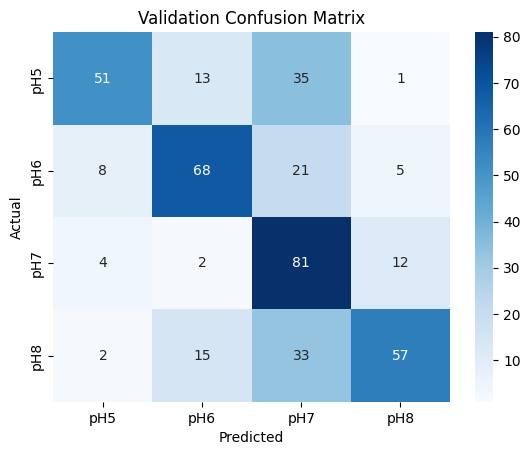


📊 Test Performance:
              precision    recall  f1-score   support

         pH5       0.89      0.61      0.73       106
         pH6       0.68      0.77      0.72       104
         pH7       0.56      0.84      0.67       102
         pH8       0.72      0.49      0.58       102

    accuracy                           0.68       414
   macro avg       0.71      0.68      0.68       414
weighted avg       0.71      0.68      0.68       414



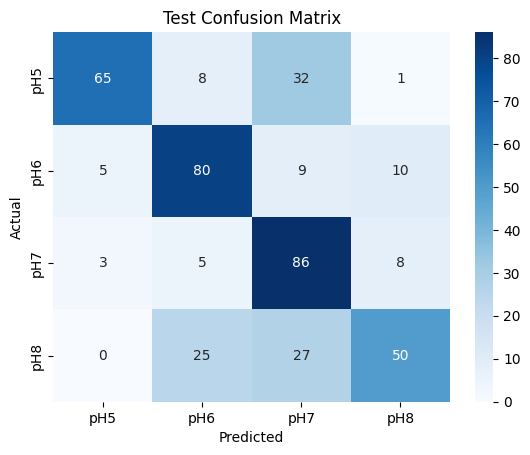


🔍 Extracting features for Random Forest...


/Users/lipisinghal/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lipisinghal/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration
data_dir = "Split_Data"  # Your dataset path
batch_size = 32
num_epochs = 15
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Helper to load all time points together
def load_combined_dataset(split):
    datasets_list = []
    split_path = os.path.join(data_dir, split)
    for time_point in os.listdir(split_path):
        time_path = os.path.join(split_path, time_point)
        if os.path.isdir(time_path):
            ds = datasets.ImageFolder(time_path, transform=transform)
            datasets_list.append(ds)
    return torch.utils.data.ConcatDataset(datasets_list)

# Load datasets
train_dataset = load_combined_dataset("train")
val_dataset = load_combined_dataset("val")
test_dataset = load_combined_dataset("test")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation function
def evaluate(loader, split_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(f"\n📊 {split_name} Performance:")
    print(classification_report(all_labels, all_preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Final evaluation
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")

# ----------------------------------
# 🔁 RANDOM FOREST USING RESNET FEATURES
# ----------------------------------
print("\n🔍 Extracting features for Random Forest...")

# Remove the FC layer from trained model
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor.load_state_dict(model.state_dict())  # Use trained weights
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Feature extraction
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feats = feature_extractor(images).cpu().numpy()
            features.extend(feats)
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train_rf, y_train_rf = extract_features(train_loader)
X_val_rf, y_val_rf = extract_features(val_loader)
X_test_rf, y_test_rf = extract_features(test_loader)

# Flatten features (ResNet18 output shape: (batch, 512, 1, 1) or (batch, 512))
X_train_rf = X_train_rf.reshape(X_train_rf.shape[0], -1)
X_val_rf = X_val_rf.reshape(X_val_rf.shape[0], -1)
X_test_rf = X_test_rf.reshape(X_test_rf.shape[0], -1)

# Train Random Forest
print("🌲 Training Random Forest on extracted features...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Evaluate RF
def evaluate_rf(X, y, split_name):
    preds = rf.predict(X)
    print(f"\n🌲 RF - {split_name} Performance:")
    print(classification_report(y, preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Greens")
    plt.title(f"RF {split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_rf(X_val_rf, y_val_rf, "Validation")
evaluate_rf(X_test_rf, y_test_rf, "Test")